Network Data sample:
    Zählstelle  2304-2412_route_count  23-04_route_count  23-05_route_count  \
0   01-MI-AL-W                21777.0              192.0             1540.0   
1  02-MI-JAN-N                13241.0              164.0             1218.0   
2  02-MI-JAN-S                13577.0              162.0             1232.0   
3  03-MI-SAN-O                10093.0              106.0              600.0   
4  03-MI-SAN-W                11921.0              146.0              795.0   

   23-06_route_count  23-07_route_count  23-08_route_count  23-09_route_count  \
0             1932.0             1388.0             1216.0             1504.0   
1             1505.0              973.0              948.0             1104.0   
2             1598.0             1055.0             1042.0             1225.0   
3              843.0              691.0              589.0              767.0   
4             1062.0              778.0              750.0              889.0   

   23-10_route_co

/tmp/ipykernel_712318/2734443869.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bike_data['ScaledCount'] = filtered_bike_data['TotalCount'] * scaling_factor


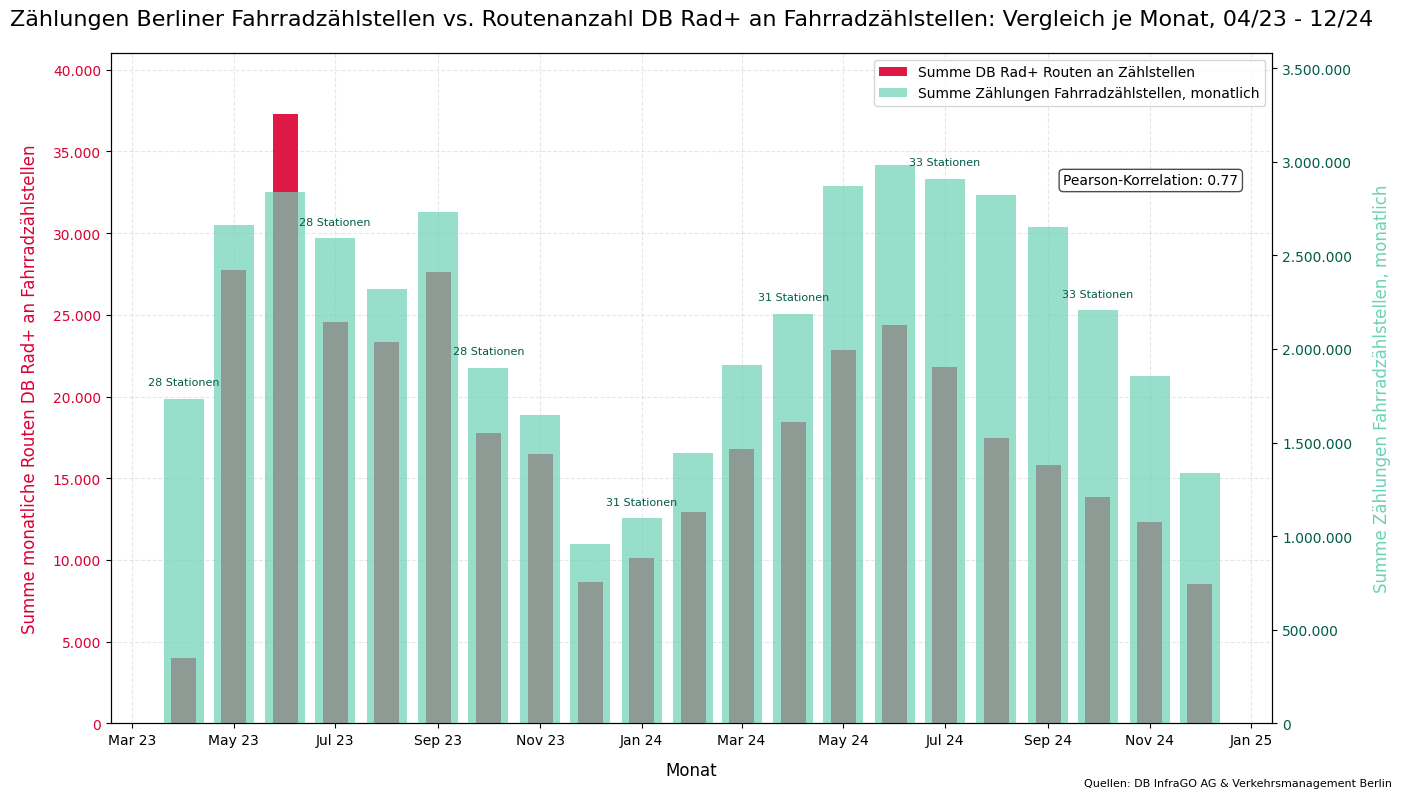

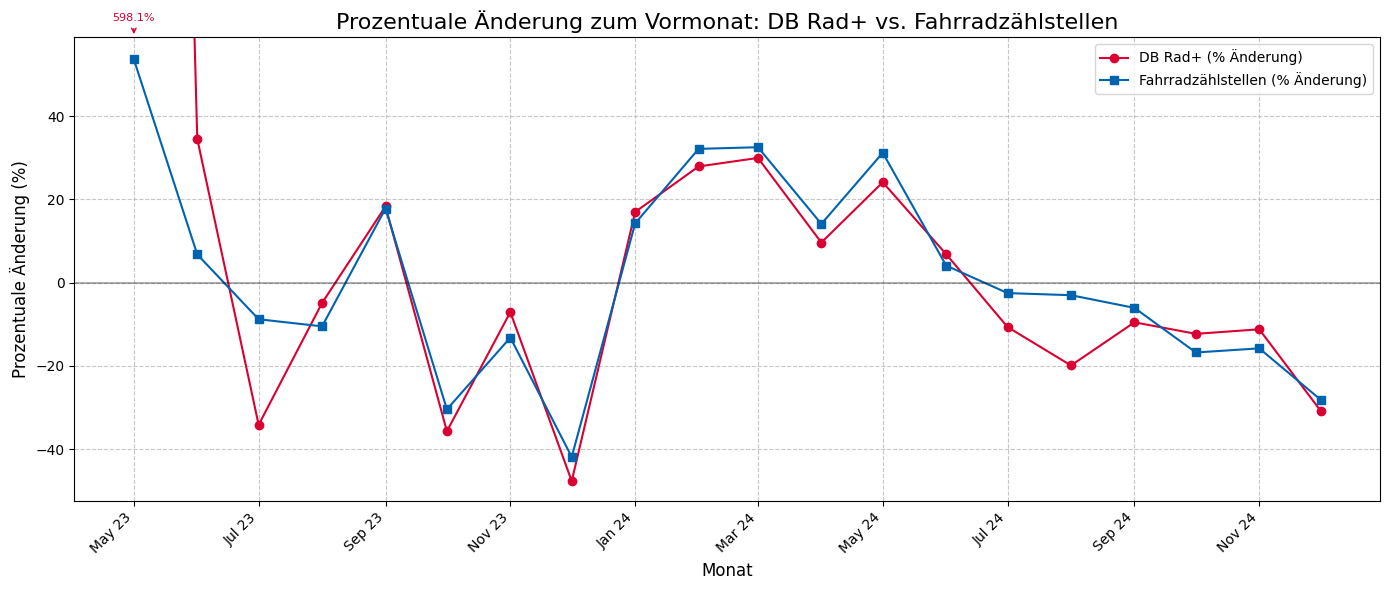


Analysis complete! All visualizations saved to the 'analysis_results' directory.


In [3]:
# Vergleich DB Rad+ route_count neben Fahrradzählstellen je Monat vs. Fahrradzählungen Berliner Fahrradzählstellen je Monat
# Inklusive Pearson-Korrelationsoeffizient und prozentualer Änderung je Monat
# Zur Erstellung des Codes wurde die generative Künstliche Intelligenz (KI) „Claude AI“ des Anbieters Anthropic in Version 3.7 genutzt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os
import re
from datetime import datetime
import matplotlib.dates as mdates

# Define Output Dir
OUTPUT_DIR = "analysis_results/002_Fahrradzaehlstellen_vs_Rad+/"

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create the output directory if it doesn't exist
os.makedirs('analysis_results', exist_ok=True)

#---------- PART 1: READING AND PROCESSING THE NEW NETWORK DATA ----------#

# Read the new parquet file with the bike count and route data
network_data = pd.read_parquet('data/fzs_with_networkdata.parquet')

# Display the first few rows to check the data
print("Network Data sample:")
print(network_data.head())

# Get all route count columns (they follow the pattern 'YY-MM_route_count')
route_count_columns = [col for col in network_data.columns if '_route_count' in col]
print("\nRoute count columns:")
print(route_count_columns)

# Filter for just the main monthly columns (like '23-04_route_count')
# Looking only for columns that match the pattern 'XX-XX_route_count' with no additional text
main_monthly_columns = []
for col in route_count_columns:
    if re.match(r'^(\d{2}-\d{2})_route_count$', col):
        main_monthly_columns.append(col)

print(f"\nSelected monthly columns ({len(main_monthly_columns)}):")
print(main_monthly_columns)

# Create dictionaries to store dates and sums
dates_list = []
months_list = []
routes_list = []

# Process each column to sum up routes for all stations
for col in main_monthly_columns:
    # Get the year and month from the column name
    year_month = col.split('_')[0]
    year_part = year_month.split('-')[0]
    month_part = year_month.split('-')[1]
    
    # Add 2000 to get full year
    year = 2000 + int(year_part)
    month = int(month_part)
    
    # Create a date object
    date_obj = pd.Timestamp(year=year, month=month, day=1)
    
    # Sum all routes across all stations for this month
    total_routes = network_data[col].sum()
    
    # Append to our lists
    dates_list.append(date_obj)
    months_list.append(date_obj.strftime('%b %y'))
    routes_list.append(total_routes)
    
    print(f"Processed {col}: {date_obj.strftime('%Y-%m-%d')} - {total_routes} routes")

# Create the DataFrame with our processed data
route_df = pd.DataFrame({
    'Date': dates_list,
    'Month': months_list,
    'Routes': routes_list
})

# Sort by date
route_df = route_df.sort_values('Date')
print("\nRoute data processed successfully:")
print(route_df)

#---------- PART 2: BIKE COUNT STATION DATA ----------#

# Read the parquet file with the bike count data
bike_counts_raw = pd.read_parquet('data/fzs_23_24.parquet')

# Display the first few rows to check the data
print("Bike count data sample:")
print(bike_counts_raw.head())

# Create installation dates dictionary (same as original code)
installation_dates = {
    '12-PA-SCH': '2012-03-01',
    '02-MI-JAN-N': '2015-04-01', '02-MI-JAN-S': '2015-04-01',
    '13-CW-PRI': '2015-04-01', '18-TS-YOR-O': '2015-04-01', '18-TS-YOR-W': '2015-04-01',
    '19-TS-MON': '2015-05-01', '27-RE-MAR': '2015-05-01',
    '03-MI-SAN-O': '2015-06-01', '03-MI-SAN-W': '2015-06-01',
    '05-FK-OBB-O': '2015-06-01', '05-FK-OBB-W': '2015-06-01', '26-LI-PUP': '2015-06-01',
    '24-MH-ALB': '2015-07-01',
    '10-PA-BER-N': '2016-05-01', '10-PA-BER-S': '2016-05-01',
    '15-SP-KLO-S': '2016-05-01', '17-SK-BRE-O': '2016-05-01', '17-SK-BRE-W': '2016-05-01',
    '20-TS-MAR-N': '2016-05-01', '20-TS-MAR-S': '2016-05-01', '21-NK-MAY': '2016-05-01',
    '23-TK-KAI': '2016-05-01',
    '15-SP-KLO-N': '2016-06-01', '06-FK-FRA-O': '2016-06-01', '06-FK-FRA-W': '2016-06-01',
    '14-CW-JU-W': '2021-07-27', '14-CW-JU-O': '2021-07-27',
    '01-MI-AL-W': '2021-12-16',
    '11-PA-SE-N': '2022-10-06',
    '04-MI-NO': '2023-10-16',
    '16-SP-NO-O': '2023-11-22', '16-SP-NO-W': '2023-11-22',
    '07-FK-ST': '2024-04-22', '09-PA-SA-S': '2024-04-22'
}

# Process the bike count data (same as original code)
def process_bike_data(df):
    # Ensure 'Datum' column is a datetime
    df['Datum'] = pd.to_datetime(df['Datum'])
    
    # Get all station columns (excluding 'Datum')
    station_columns = [col for col in df.columns if col != 'Datum']
    
    # Determine active stations for each month
    def active_stations_per_month(month_start):
        return {station: (station in installation_dates and 
                          pd.to_datetime(installation_dates[station]) <= month_start)
                for station in station_columns}
    
    # Create a list to hold the monthly aggregated data
    monthly_data = []
    
    # Get unique months in the dataset
    months = pd.date_range(start=df['Datum'].min().replace(day=1), 
                           end=df['Datum'].max().replace(day=1), 
                           freq='MS')
    
    for month_start in months:
        month_end = month_start + pd.offsets.MonthEnd(1)
        
        # Filter data for the current month
        month_data = df.set_index('Datum').loc[month_start:month_end]
        
        # Get active stations for this month
        active = active_stations_per_month(month_start)
        
        # Calculate monthly sum for active stations
        month_sum = 0
        active_count = 0
        
        for station in station_columns:
            if active[station]:
                # Sum non-NaN values
                station_sum = month_data[station].sum(skipna=True)
                if not pd.isna(station_sum):
                    month_sum += station_sum
                    active_count += 1
        
        # Add to result if we have active stations
        if active_count > 0:
            monthly_data.append({
                'Date': month_start,
                'TotalCount': month_sum,
                'ActiveStations': active_count
            })
    
    return pd.DataFrame(monthly_data)

# Process the bike count data
monthly_bike_data = process_bike_data(bike_counts_raw)

# Print the monthly aggregated data
print("\nMonthly aggregated bike count data:")
print(monthly_bike_data.head())

# Filter to match the route data timeframe
start_date = route_df['Date'].min()
end_date = route_df['Date'].max()
filtered_bike_data = monthly_bike_data[
    (monthly_bike_data['Date'] >= start_date) & 
    (monthly_bike_data['Date'] <= end_date)
]

# Scale the bike count data to be comparable with route data
route_avg = route_df['Routes'].mean()
bike_avg = filtered_bike_data['TotalCount'].mean()
scaling_factor = route_avg / bike_avg

filtered_bike_data['ScaledCount'] = filtered_bike_data['TotalCount'] * scaling_factor

#---------- PART 3: DUAL-AXIS COMPARISON VISUALIZATION ----------#

# Create a figure for the comparison
fig, ax1 = plt.subplots(figsize=(14, 8))

# Define colors
route_color = '#DB0032'  # DB red
bike_color = '#6cd2b6'  # Mint green for bike counts as requested
label_color = '#005c48'  # Darker green for station count labels

# Set zorder to control which elements are in front/behind
bike_zorder = 1  # Lower zorder means further back
route_zorder = 2    # Higher zorder means in front

# Calculate bar widths - make bike count bars wider but behind route bars
route_bar_width = 15
bike_bar_width = 24

# Plot bike count station data as histogram on secondary y-axis first (so it appears behind)
ax2 = ax1.twinx()
bike_bars = ax2.bar(filtered_bike_data['Date'], filtered_bike_data['TotalCount'], 
               width=bike_bar_width, alpha=0.7, color=bike_color, 
               label='Summe Zählungen Fahrradzählstellen, monatlich',
               zorder=bike_zorder)

# Plot route data as histogram on primary y-axis (on top)
route_bars = ax1.bar(route_df['Date'], route_df['Routes'], 
             width=route_bar_width, alpha=0.9, color=route_color, 
             label='Summe DB Rad+ Routen an Zählstellen',
             zorder=route_zorder)

# Format primary y-axis (left - Route data)
ax1.set_xlabel('Monat', fontsize=12, labelpad=10)
ax1.set_ylabel('Summe monatliche Routen DB Rad+ an Fahrradzählstellen', fontsize=12, labelpad=10, color=route_color)
ax1.tick_params(axis='y', labelcolor=route_color)
ax1.grid(True, linestyle='--', alpha=0.3)

# Format secondary y-axis (right - Bike counts)
ax2.set_ylabel('Summe Zählungen Fahrradzählstellen, monatlich', fontsize=12, labelpad=15, color=bike_color)
ax2.tick_params(axis='y', labelcolor=label_color)

# Format y-axis tick labels to avoid scientific notation
from matplotlib.ticker import FuncFormatter
def format_thousands(x, pos):
    return f'{int(x):,}'.replace(',', '.')  # Use German format with dots as thousand separators
    
ax1.yaxis.set_major_formatter(FuncFormatter(format_thousands))
ax2.yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Scale the second y-axis to make the patterns overlap appropriately
ax2_min = 0
ax2_max = filtered_bike_data['TotalCount'].max() * 1.2
ax1_min = 0
ax1_max = route_df['Routes'].max() * 1.1

# Apply the scaling to keep relative patterns the same
ax2.set_ylim(ax2_min, ax2_max)
ax1.set_ylim(ax1_min, ax1_max)

# Annotate the number of active stations
for idx, row in filtered_bike_data.iterrows():
    if idx % 3 == 0:  # Add annotation every 3 months to avoid clutter
        ax2.annotate(f"{int(row['ActiveStations'])} Stationen", 
                    (row['Date'], row['TotalCount']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=8,
                    color=label_color,
                    zorder=route_zorder+1)

# Title and formatting
plt.title('Zählungen Berliner Fahrradzählstellen vs. Routenanzahl DB Rad+ an Fahrradzählstellen: Vergleich je Monat, 04/23 - 12/24', fontsize=16, pad=20)

# Format x-axis dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45, ha='right')

# Create combined legend for both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Calculate correlation between the route counts and bike counts
common_months = pd.merge(
    route_df, 
    filtered_bike_data,
    on='Date',
    how='inner'
)

correlation = common_months['Routes'].corr(common_months['ScaledCount'])
print(f"\nCorrelation between DB Rad+ routes and bike count stations: {correlation:.4f}")

# Add the correlation value in a text box under the legend
correlation_text = f"Pearson-Korrelation: {correlation:.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax1.text(0.82, 0.82, correlation_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

# Add source citation
plt.figtext(0.99, 0.01, 'Quellen: DB InfraGO AG & Verkehrsmanagement Berlin', ha='right', fontsize=8)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(OUTPUT_DIR, "FZS_vs_DBRad+.png"), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Calculate monthly percentage changes for both datasets
common_months['Route_Pct_Change'] = common_months['Routes'].pct_change() * 100
common_months['Bike_Pct_Change'] = common_months['ScaledCount'].pct_change() * 100

# Plot the percentage changes to see if the relative changes match
plt.figure(figsize=(14, 6))

# First identify outliers to properly scale the y-axis
route_changes = common_months['Route_Pct_Change'].dropna()
bike_changes = common_months['Bike_Pct_Change'].dropna()

# Get data without the extreme outlier
outlier_threshold = 70  # Set to ±70%
filtered_route = route_changes[(route_changes >= -outlier_threshold) & (route_changes <= outlier_threshold)]
filtered_bike = bike_changes[(bike_changes >= -outlier_threshold) & (bike_changes <= outlier_threshold)]

# Find min and max for scaling, adding 10% margin
y_min = min(filtered_route.min(), filtered_bike.min()) * 1.1
y_max = max(filtered_route.max(), filtered_bike.max()) * 1.1

# Plot the data
plt.plot(common_months['Date'], common_months['Route_Pct_Change'], 
         marker='o', linestyle='-', color='#DB0032', 
         label='DB Rad+ (% Änderung)')
plt.plot(common_months['Date'], common_months['Bike_Pct_Change'], 
         marker='s', linestyle='-', color='#0063AF', 
         label='Fahrradzählstellen (% Änderung)')

# Set the y-axis limits to focus on the main data range
plt.ylim(y_min, y_max)

# Create a text annotation for outliers
outliers = common_months[abs(common_months['Route_Pct_Change']) > outlier_threshold]
if not outliers.empty:
    for idx, row in outliers.iterrows():
        plt.annotate(f"{row['Route_Pct_Change']:.1f}%", 
                    (row['Date'], y_max),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='#DB0032',
                    fontsize=8,
                    arrowprops=dict(arrowstyle='->', color='#DB0032'))

plt.title('Prozentuale Änderung zum Vormonat: DB Rad+ vs. Fahrradzählstellen', fontsize=16)
plt.xlabel('Monat', fontsize=12)
plt.ylabel('Prozentuale Änderung (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "FZS_vs_DBRad+_monthly.png"), dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis complete! All visualizations saved to the 'analysis_results' directory.")